# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2022-2023

\require{mhchem}  
\require{dcolumn}
\require{longtable}
\require{array}
\require{multirow}


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.integrate import odeint
from scipy.special import gammaln, digamma, polygamma

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 9, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
$$
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
$$
We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

#### Question 1
1. Adapt the Gillespie code from week 10 exercises to simulate the Telegraph model. Use the template below that also contains initial values.
2. Discuss whether the proposed initial rates are relevant biologically.

**Answer: 
Initial rates: 
s = 20 # number of initiations per minute; k = 0.02 # 1/k = 50 min; k_off = 1/15 #t_on = 1/k_off = 15 min; k_on  = 1/120 #t_off = 1/k_on = 120 min**

**We saw during week 10 lecture that the transcription initiation rate is at fastest  per hour, i.e. s = 1. The initial rate of 20 is much larger, yet it still falls in a biological possible range as the maximal possible initiation rate is 2 initiations per second per allele. 
Common degradation rate in mammalian cell is about 1 every 10h, i.e. k = 0.01. The initial rate is somewhat smaller but still reasonable. The half-life of mRNA varies between cells. A degradation rate of 0.02 results in a half-life t = ln(2)/k = 34 min, which is relevant as it globin mRNA can last several hours and others can lasts only a few minutes. 
Regarding promoter activation and inactivation rates, we have that the inactivation rate is faster than the activation rate. This means that the promoter is more often in an inactive state, which is adequation with the fact that transcription is a rare event. If we consider a transcription event once every hour, we need the promoter to be active at least once every hour. Hence k_on should be larger, greater than 1/60.**

3. Vary the different rates, plot representative traces and comment. Try to find cases that show qualitatively different regimes of the model.


#### Gillespie template

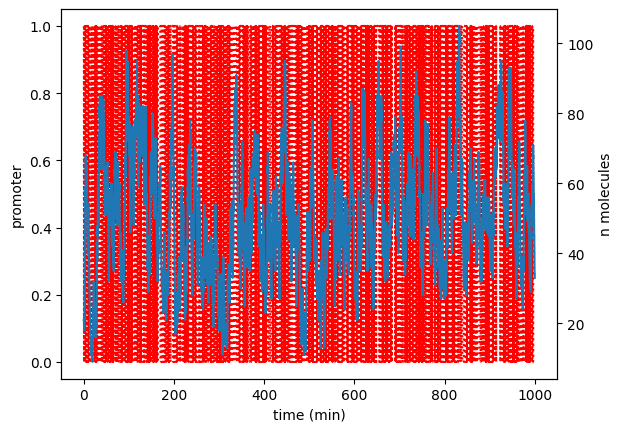

In [12]:
#initial conditions for the state (g,n) at time t
g = 1
n = 20 
t = 0

tp = 0
DT = 0.01
t_end = 1000 #min

nprint = []
gprint = []
tprint = []

s = 20 # number of initiations per minute
k = 0.2 # 1/k = 50 min
k_off = 1/1 #t_on = 1/k_off = 15 min
k_on  = 1/1 #t_off = 1/k_on = 120 min

while t < t_end:
    
    if g == 1:
        rates = [s, k*n, k_off]
        rates_tot = sum(rates)
    
        #pick the next time interval
        dt = np.random.exponential(scale = 1/rates_tot)
        t = t + dt
    
        #pick a random reaction to happen
        rand_uniform = np.random.random()
    
        #production
        if rand_uniform <= (rates[0] / rates_tot):
            n = n + 1
        
        #degradation
        elif ((rand_uniform>(rates[0]/rates_tot)) and (rand_uniform<=((rates[0]+rates[1])/rates_tot))):
            n = n - 1 
   
        #inactivation
        else:
            g = 0
            
    else:
        rates = [k*n, k_on]
        rates_tot = sum(rates)
        
        dt = np.random.exponential(scale = 1/rates_tot)
        t = t + dt
    
        rand_uniform = np.random.random()
    
        #degradation
        if rand_uniform <= (rates[0] / rates_tot):
            n = n - 1 
        
        #activation
        else: 
            g = 1
    
    #this is to have equally spaced output times
    while tp<t and t<=t_end:
        nprint.append(n)
        gprint.append(g)
        tprint.append(tp)
        tp += DT


#plot of telegraph process 
fig, ax1 = plt.subplots()
ax1.plot(tprint,gprint, 'r:')
ax1.set_xlabel("time (min)")
ax1.set_ylabel("promoter")
ax2 = ax1.twinx()
ax2.plot(tprint,nprint)
ax2.set_ylabel("n molecules")
plt.show()

####  Poisson and Negative binomal distributions

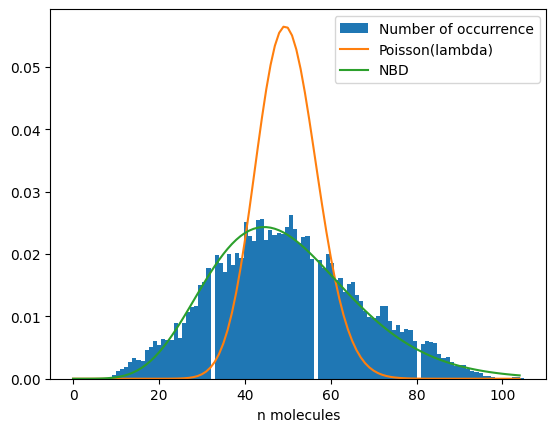

In [13]:
#  poisson distribution
def Poisson(lam, counts):
    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

# negative binomial distribution
def convert_params(mu, theta):
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def pmf(counts, mu, theta):
    return nbinom.pmf(counts, *convert_params(mu, theta))


#plot occurence
plt.hist(nprint, bins=100, label='Number of occurrence', density=True)

#Poisson 
lam = np.mean(nprint)
nn = np.arange(max(nprint))
p = Poisson(lam, nn)
plt.plot(nn, p, label='Poisson(lambda)')

#Negative binomial
mu = np.mean(nprint) 
theta = (mu ** 2)/(np.std(nprint)**2 - mu)
b = pmf(nn, mu, theta)
plt.plot(nn, b, label='NBD')

plt.xlabel("n molecules")
plt.legend()
plt.show()

#### Question 2
1. Study the distribution of mRNA numbers, what type of distribution do you expect/observe?

**With the initial rates, we have an exponiental distribution (that the negative binomial fits for very low value of theta) of mRNA numbers, which is the distribution for mRNA synthesis and degradation process when assumed Markovian. However, the distribution of mRNA numbers is highly dependent on the rates.** 

2. Identify a regime where you find the Poisson distribution. Explain.

**For $s = 12$, $k = 0.96$, $k_{off}$ --> 0, $k_{on}$ --> 1, we have a regime where we find a Poisson distribution. Indeed, when the inactivation rate of the promoter becomes very low, the promoter is active most of the time and it is then more likely that mRNA be synthesized. A higher degradation rate prevents accumulation of molecules. We then get an approximation of the constitutive birth-death process, which is a poissonian distribution. Note that for $k_{off} ≠ 0$, we have a transient in the first bins that we can discard to get the Poisson distribution.**

3. Identify a regime where you find another distribution, for example the Negative Binomial.

**We can find a regime that fits a Negative Binomial distribution. when increasing the degradation rate, and letting k_off --> 1, k_on --> 1. This simulate a fast fluctuation of the promoter' state. We could argue that such a situation is probably not biologically relevant.** 

4. In both cases, discuss how the model parameters relate to the parameters of the distributions.

**For Poisson, only the mean of mRNA numbers comes into play, which depends on $s$ and $k$. By taking values that mimic a birth-death process, i.e. the promoter is always active, a high synthesis rate, a high degradation rate, we allow oscillatoty behavior, with a higher mRNA baseline. Such parameters allow a somewhat symmetric mRNA numbers distribution. 
The Negative Binomial can approximate a Poisson mixture, with a coefficient of variation (CV), which we find in the expression of the variance (the variance of the negative binomial is the variance of Poisson plus an extra term): 
\begin{equation*}
var = mean + mean^2/CV
\end{equation*}  
Here, we consider $\theta$ as the coefficient of variation, which thus depends on the mean and the variance of the distribution of mRNA numbers. We notice that when $\theta$ tends to infinity, the Negative Binomial approximates a Poisson distribution. When the 'on' states are very short, the mRNA distribution has a long tail and a high variance, closer to a Negative binomial distribution.**

5. Find a situation where the distribution is bimodal. Explain.

**The distribution of mRNA numbers is bimodal when the promoter state transition rates are low, i.e. they spend a long time in the 'on' or 'off' state. We get two peaks in that case because with the promoter 'on', many mRNAs can be synthesized, and when the promoter is 'off', the synthesized mRNA has time to deplete. Hence, we have a high number of occurence for large number of mRNAs, and for small number of mRNAs.**